# Statistics & Representation

*State of the Interactomes: an evaluation of molecular networks for generating biological insights.* Wright, SN et al. [https://doi.org/10.1101/2024.04.26.587073]  
This notebook contains code and results related to:
* Figure 1
* Figure 2A-E
* Supplemental Figure 2B

**Note: due to the size of network data sets utilized in this study, this notebook draws on summarized results rather than re-evaluating all networks directly.**

For implementation of the network processing pipeline, please see `ExampleUsage/NP_NetworkProcessing.README.md`

## Setup

Load necessary packages

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from neteval.network_statistics import NetworkStats, load_network_names
from neteval.node_annotation import *
import os
from scipy.stats import spearmanr
from scipy.stats import fisher_exact
from collections import defaultdict
import pickle
from scipy.stats import fisher_exact

/cellar/users/snwright/anaconda3/envs/pcnet_py3/lib/python3.10/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.1.0)/charset_normalizer (2.0.7) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


Setup visualization parameters

In [2]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.25

Relevant Directories

In [3]:
gitdir = os.path.dirname(os.getcwd())
figdir = os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Figures/')
network_names = load_network_names(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/network_names_final.txt'))

### Load Data

In [5]:
network_features = pd.read_csv(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/Fig1A_network_feature_data.csv'), index_col=0)
stats = NetworkStats(os.path.join(gitdir, 'Data/example_prefix_file.txt'), datadir=os.path.join(gitdir, 'Data/example_outputs/'))
annotation_data = pd.read_csv(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/Fig2A_gene_annotations.csv'), index_col=0, low_memory=False)
pc_genes = pd.read_csv(os.path.join(gitdir, 'Data/protein_coding_genes.txt')).GeneID.values

In [6]:
# mrna data
rna_file = os.path.join(gitdir, 'Data/gtex_median_processed_1.tsv.gz')
rna_data = ExpressionData(rna_file, datatype='mrna', min_obs=10)
rna_data.data.Entrez = rna_data.data.Entrez.astype(int)
rna_data.data.set_index('Entrez', drop=True, inplace=True)
gene_mean_rna = rna_data.data.loc[:, rna_data.data.columns[2:-1]].mean(axis=1)
gene_mean_rna.index.name=None

In [7]:
# protein data
prot_file = os.path.join(gitdir, 'Data/HPA_normal_tissue_expression.tsv.gz')
prot_data= ExpressionData(prot_file, datatype='protein', min_obs=1000)
gene_mean_prot = prot_data.data.iloc[:, 2:].set_index('Entrez', drop=True).mean(axis=1)

Query batch 0 - 1000
Query batch 1000 - 2000
Query batch 2000 - 3000
Query batch 3000 - 4000
Query batch 4000 - 5000
Query batch 5000 - 6000
Query batch 6000 - 7000
Query batch 7000 - 8000
Query batch 8000 - 9000
Query batch 9000 - 10000
Query batch 10000 - 11000
Query batch 11000 - 11167


In [8]:
conservation_df = pd.read_csv(os.path.join(gitdir, 'Data/gene_conservation_scores.txt'), index_col=0, sep='\t')

## Figure 1

In [9]:
network_features['xOrthology'] = network_features['Incorporates Orthology'].apply(lambda x: 'x' if x == 'x' else '')
network_features['Incorporates Orthology'] = network_features['Incorporates Orthology'].apply(lambda x: 1 if x == 'x' else int(x))
network_features['Incorporates Orthology'].unique()
network_features.columns = [col.split('Type - ')[1] if 'Type - ' in col else col for col in network_features.columns ]

### Fig1A Network Feature Bar Chart

In [10]:
bar_colors = ['#ffa500', '#44cf6c', '#73c7e7'] + ['#886194']*13 + ['gold', '#db6f57', '#269ca6']
unique_colors = ['#ffa500', '#44cf6c', '#73c7e7', '#886194', 'gold', '#db6f57', '#269ca6']

In [11]:
bar_data = network_features.iloc[:, [0,2,1,3] + [i for i in range(9,23) if i != 11] + [4,7,5]]
bar_data = pd.DataFrame({'frac':bar_data.set_index("Name", drop=True).sum(axis=0)/len(bar_data), 'color':bar_colors})
bar_data['Name'] = bar_data.index
bar_data['Name'] = bar_data['Name'].apply(lambda x: x.split('Type - ')[1] if 'Type - ' in x else x)
bar_data.set_index('Name', drop=True, inplace=True)
bar_data['Name'] = bar_data.index

In [12]:
xOrtho = len(network_features.xOrthology.sum())/len(bar_data)
order = ['Composite', 'Curated', 'Experimental'] + [ x for x in ['Physical', 'Regulation', 'Metabolic', 'Pathway', 'Signaling', 'Localization', 'Genetic', 'Functional', 'CoCitation',
                                                    'Disease', 'CoExpression', 'Domain/Structure', 'Genome']] + ['Incorporates Orthology', 'In Original Study']
bar_data = bar_data.loc[order, :]

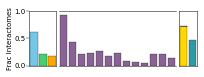

In [15]:
plt.rcParams['hatch.linewidth'] = 0.5
_, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize = (3,1), sharey=True, gridspec_kw={'width_ratios':[3, 13, 2], 'wspace':0.05})
sns.barplot(data = bar_data.iloc[0:3, :], x='Name', y='frac', hue='color', palette=unique_colors[0:3][::-1], dodge=False, legend=False, edgecolor='black', linewidth=0.25, order=order[0:3], alpha=0.99, ax=ax1, saturation=1)#order=plot_data.columns)
sns.barplot(data = bar_data.iloc[3:16, :], x='Name', y='frac', hue='color', palette=unique_colors[3:4], dodge=False, legend=False, edgecolor='black', linewidth=0.25, order=order[3:16], alpha=0.99, ax=ax2, saturation=1)#order=plot_data.columns)
sns.barplot(data = bar_data.iloc[16:, :], x='Name', y='frac', hue='color', palette=[unique_colors[i] for i in [4,6]], dodge=False, legend=False, edgecolor='black', linewidth=0.25, order=order[16:], alpha=0.99, ax=ax3, saturation=1)#order=plot_data.columns)
xOrtho = len(network_features.xOrthology.sum())/len(network_features)
ortho_bottom = bar_data.loc['Incorporates Orthology', 'frac'] - xOrtho

sns.barplot(x = ['Incorporates Orthology'], y = [xOrtho], color='gold', bottom = ortho_bottom, hatch = 'XXXXXXX', edgecolor='black', linewidth=0.5, alpha=0.99, ax=ax3, saturation=1)

for ax in [ax1, ax2, ax3]:
    _ = ax.set_xticks('')
    ax.set_xlabel(None) 
    
#remove left spine
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.tick_params(axis='y', length=0)
ax3.tick_params(axis='y', length=0)
plt.ylim(0,1)
ax1.set_ylabel('Frac Interactomes')

plt.savefig(figdir + "Fig1A_network_features_bar.jpg", bbox_inches='tight', dpi=400)

### Fig1B Network Sizes

Example to load network statistics using neteval's NetworkStatistics

In [16]:
stats = NetworkStats(os.path.join(gitdir, 'Data/example_prefix_file.txt'), datadir=os.path.join(gitdir, 'Data/example_outputs/'))

In [17]:
print(stats.network_node_counts['dip'])
print(stats.network_edge_counts['dip'])
print(stats.nodes) # All unique nodes across all networks
print(stats.node_counts) # Number of networks each node is in

3202
11519
{1, 2, 131076, 16, 18, 19, 21, 22, 23, 25, 27, 29, 30, 34, 35, 36, 37, 38, 39, 43, 131118, 47, 48, 50, 51, 52, 58, 59, 60, 71, 81, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 100, 101, 102, 103, 104, 107, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 120, 123, 128, 132, 133, 196743, 136, 135, 142, 147, 150, 151, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 174, 177, 178, 181, 182, 183, 185, 186, 189, 190, 191, 196, 197, 204, 207, 208, 210, 211, 213, 214, 217, 219, 223, 224, 226, 229, 230, 231, 238, 240, 242, 246, 267, 268, 269, 271, 273, 274, 196883, 275, 284, 285, 287, 288, 290, 291, 292, 293, 302, 306, 307, 308, 309, 310, 311, 317, 322, 324, 327, 328, 329, 330, 331, 332, 333, 334, 335, 338, 348, 350, 351, 353, 354, 355, 356, 360, 362, 366, 367, 369, 372, 374, 375, 378, 381, 382, 383, 384, 387, 388, 389, 391, 392, 393, 394, 395, 396, 397, 398, 402, 403, 131474, 405, 406, 407, 408, 409, 427, 429, 439, 440, 444, 445, 65985, 462, 463, 466, 467, 468, 66005, 471, 

Load the summarized results for all networks evaluated in *State of the Interactomes*

In [18]:
size_data = pd.read_csv(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/Fig1B_network_sizes.csv'), index_col=0)

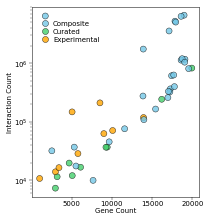

In [19]:
_ = plt.figure(figsize=(3, 3.5))
sns.scatterplot(data=size_data, x='Gene Count', y='Interaction Count', hue="Type", palette=['#73c7e7', '#44cf6c', '#ffa500'], 
                hue_order = ['Composite', 'Curated', 'Experimental'], alpha=0.8, edgecolor='black')
#add annotation for each point
#for i, row in size_data.iterrows():
    #plt.text(row['Gene Count'], row['Interaction Count'], row['pref'], fontsize=6, alpha=0.8)
plt.yscale("log")
ax = plt.gca()
ax.legend(labels=[None, 'Composite', 'Curated', 'Experimental'], frameon=False, 
          labelspacing=0.25, handletextpad=0.1) #reverse=True
plt.savefig(figdir+"Fig1B_network_sizes.jpg", bbox_inches='tight', dpi=400)

## Figure 2

### Fig2A Gene Network Coverage

In [24]:
annotation_data = pd.read_csv(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/Fig2A_gene_annotations.csv'), index_col=0, low_memory=False)


In [25]:
pc_counts = [h.get_height() for h in sns.histplot(annotation_data[annotation_data.PC].db_count, bins=[i for i in range(48)]).patches]
plt.close()

In [26]:
other_counts = [h.get_height() for h in sns.histplot(annotation_data[(~annotation_data.PC) & (annotation_data.db_count > 0)].db_count, bins=[i for i in range(48)]).patches]
plt.close()

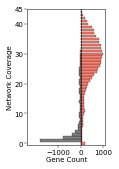

In [27]:
_ = plt.figure(figsize=(1.4, 2.5))

plt.barh(width =np.array(pc_counts), y = [i for i in range(47)], color='salmon', edgecolor='black')#, linewidth=0.25)
plt.barh(width=np.array(other_counts)*-1, y = [i for i in range(47)], color='grey', edgecolor='black')#, linewidth=0.24)
plt.ylabel("Network Coverage")
plt.xlabel("Gene Count")
plt.vlines(x=0, ymin=-1, ymax=46, color='black', linewidth=0.5)
plt.ylim(-0.5, 45)
plt.xlim(-2400, 1100)
_ = plt.yticks([0,10,20,30,40,45])
_ = plt.xticks([-1000, 0, 1000])
#plt.gca().tick_params(axis='x', which='major', length=4, pad=1)
plt.savefig(figdir+"Fig2A_gene_network_coverage.jpg", dpi=400, bbox_inches='tight')

### Fig2B Gene Type Coverage

In [28]:
annotation_data['InDB'] = annotation_data['db_count'] > 0

In [29]:
indb_counts = annotation_data.groupby(['Locus group']).InDB.sum()
totals = annotation_data['Locus group'].value_counts()

In [30]:
type_coverage = pd.concat([pd.DataFrame({'count': indb_counts, 'group':indb_counts.index, 'type':'InDB'}),
           pd.DataFrame({'count': totals, 'group':totals.index, 'type':'total'})]).reset_index(drop=True)

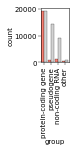

In [31]:
_ = plt.figure(figsize=(0.5,1))
sns.barplot(data=type_coverage, x='group', y='count', hue='type', palette=['salmon', 'lightgrey'], 
            order=['protein-coding gene', 'pseudogene', 'non-coding RNA', 'other'], saturation=1, edgecolor='black', linewidth=0.25, legend=False)
ax = plt.gca()
ax.tick_params(axis='x', rotation=90)
plt.savefig(figdir+"Fig2B_type_coverage.jpg", dpi=400, bbox_inches='tight')

### Fig2C - network biases

#### Example Analysis

In [32]:
prefix_file = os.path.join(gitdir, 'Data/example_prefix_file.txt')
stats = NetworkStats(prefix_file, datadir = os.path.join(gitdir, 'Data/example_outputs/'))

In [33]:
# format citation data
annotation_data['GeneID'] = annotation_data.index.astype(int)
cite_df = annotation_data[annotation_data.GeneID.isin(pc_genes)].set_index('GeneID')
cite_df.index.name=None

In [34]:
# Format mrna data
gene_mean_rna_df = pd.DataFrame({'Expression':gene_mean_rna})
gene_mean_rna_df['GeneID'] = gene_mean_rna_df.index
gene_mean_rna_df = gene_mean_rna_df[gene_mean_rna_df.GeneID.isin(pc_genes)].set_index('GeneID')
gene_mean_rna_df.index.name=None

In [35]:
# Format protein abundance data
gene_mean_prot_df = pd.DataFrame({'Abundance':gene_mean_prot})
gene_mean_prot_df.index.name = None
gene_mean_prot_df['GeneID'] = gene_mean_prot_df.index.astype(int)
gene_mean_prot_df = gene_mean_prot_df[gene_mean_prot_df.GeneID.isin(pc_genes)].set_index('GeneID')
gene_mean_prot_df.index.name = None

In [36]:
# format conservation_data
conservation_df = conservation_df[conservation_df['entrezgene'].isin(pc_genes)].set_index('entrezgene')
conservation_df.index.name=None


In [37]:
citation_bias_df = permutation_test_wrapper(stats, cite_df, 'CitationCount')
mrna_bias_df = permutation_test_wrapper(stats, gene_mean_rna_df, 'Expression')
prot_bias_df = permutation_test_wrapper(stats, gene_mean_prot_df, 'Abundance')
cons_bias_df = permutation_test_wrapper(stats, conservation_df, 'mean')


100%|██████████| 10000/10000 [00:01<00:00, 6858.29it/s]


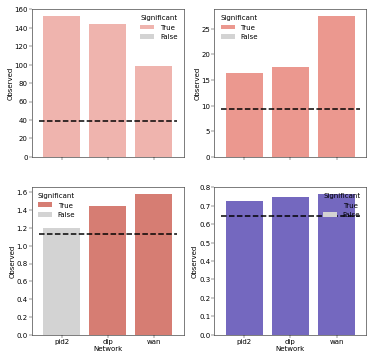

In [38]:
_, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(6,6), sharex=True)
colors= ['#faaba3', '#fa8c80', '#e67063', 'slateblue']
for i, df in enumerate([citation_bias_df, mrna_bias_df, prot_bias_df, cons_bias_df]):
    sns.barplot(df, x='Network', y='Observed', hue='Significant', palette=[colors[i], 'lightgrey'], 
                hue_order=[True, False], ax=[ax1, ax2, ax3, ax4][i])
    ax=[ax1, ax2, ax3, ax4][i]
    ax.hlines(y= df.Permuted.mean(), xmin=-0.5, xmax=2.5, color='black', linestyle='--')

#### Full Plot

In [40]:
bias_data = pd.read_csv(os.path.join(gitdir ,'StateOfTheInteractomes_Notebooks/Data/Fig2C_bias_results.csv'), index_col=0, low_memory=False)


In [41]:
def plot_bar_v(results,metric, unit,stat, ax=None, color='indianred', ylim=(0, 30), **kwargs):
    
    sns.barplot(results, x='Name', y='Observed', hue='Significant', palette=['lightgrey', color], ax=ax, 
                legend=False, saturation=1, **kwargs)
    #plt.ylim(-0.5, 47.5)
    if ax is None:
        ax = plt.gca()
        _ = plt.figure(figsize=(3, 8))
    ax.hlines(y=results.Permuted.mean(), xmin=-0.5, xmax=47.5, color='black', linestyle='dashed', linewidth=0.5)
    ax.set_ylabel(f'{stat} {metric} ({unit})', fontsize=8)
    ax.set_xlim(44.5, -0.5)
    ax.set_ylim(ylim)
    ax.tick_params(labelsize=7)
    ax.tick_params(axis='x', rotation=90)

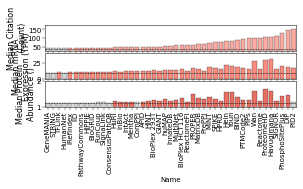

In [42]:
_, [ax1, ax2, ax3] = plt.subplots(nrows=3, ncols=1, figsize=(4.5, 1.5), gridspec_kw={'hspace':0.07}, sharex=True)

plot_bar_v(bias_data[bias_data.Annotation=='Citation'], 'Citation\n', 'Count', 'Median', ax=ax1, color='#faaba3', ylim=(25, 175),edgecolor='black', linewidth=0.25)
plot_bar_v(bias_data[bias_data.Annotation=='mRNA Expression'],'mRNA\nExpression', 'TPM', 'Median', ax=ax2, color='#fa8c80', ylim=(0, 40),edgecolor='black', linewidth=0.25)
plot_bar_v(bias_data[bias_data.Annotation=='Abundance'],'Protein\nAbundance', '', 'Median', ax=ax3, color='#e67063', ylim=(1,2),edgecolor='black', linewidth=0.25)
plt.savefig(os.path.join(figdir, 'Fig2C.jpg'), bbox_inches='tight')

In [43]:
net_order = [x.get_text() for x in ax3.get_xticklabels()]

In [44]:
bias_annot = size_data.loc[:, ('Name', 'Type')].set_index('Name')
bias_annot.index.name=None
bias_annot['value'] = 1
bias_annot['x'] = bias_annot.index

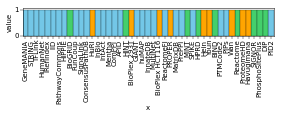

In [45]:
_ = plt.figure(figsize=(4.5, 0.5))
sns.barplot(bias_annot, x='x', y='value', width=1, hue='Type', palette=['#73c7e7', '#44cf6c', '#ffa500'], 
                hue_order = ['Composite', 'Curated', 'Experimental'], saturation=1, linewidth=0.25, edgecolor='black',
           order=net_order[::-1], legend=False)
plt.gca().tick_params(axis='x', rotation=90)
plt.savefig(os.path.join(figdir, "Updated_fig2c_annotation_bar.jpg"), bbox_inches='tight')

### Edge level statistics

In [46]:
pc_genes = pd.read_csv(os.path.join(gitdir, 'Data/protein_coding_genes.txt')).GeneID.values

In [47]:

def create_mapping(node_list, pc_genes):
    net_pc_genes = [gene for gene in node_list if gene in pc_genes]
    npc_genes = [gene for gene in node_list if gene not in pc_genes]
    print('PC Gene cutoff: ', len(net_pc_genes))
    return {node: idx for idx, node in enumerate(net_pc_genes + npc_genes)}, len(net_pc_genes)

def process_file(file_path, edge_counts, node_mapping):
    with open(file_path, 'r') as file:
        next(file)  # Skip header line
        for line in file:
            node_a, node_b, *_ = line.split()
            compressed_edge = tuple(sorted([node_mapping[int(node_a)], node_mapping[int(node_b)]]))
            edge_counts[compressed_edge] += 1

def count_edges(file_paths, node_list, pc_genes):
    node_mapping, cutoff = create_mapping(node_list, pc_genes)
    edge_counts = defaultdict(int)
    for file_path in tqdm(file_paths):
        process_file(file_path, edge_counts, node_mapping)
    return edge_counts, node_mapping, cutoff

def create_equal_bins(cite_df, nodes, num_bins=100):
    cite_data = cite_df.loc[nodes]
    cite_counts = cite_data.CitationCount.value_counts().sort_index()
    ideal_bin_size = int(cite_counts.sum()/num_bins)
    bins = []
    bin_sizes = []
    current_sum=0
    last_index=0
    for idx, value in cite_counts.iteritems():
        current_sum += value
        if current_sum > ideal_bin_size:
            bins.append(last_index)
            bin_sizes.append(current_sum - value)
            current_sum = value
        last_index=idx
    bins.append(last_index)
    bin_sizes.append(current_sum + value)
    return bins, bin_sizes

def map_nodes_to_bins(node_list,cite_df, bins):
    cite_df.fillna(0, inplace=True)
    bin_map = {}
    last_bin = 0
    for i, b in enumerate(bins):
        b=  int(b)
        bm = {c: i for c in range(last_bin, b)}
        bin_map = {**bin_map, **bm}
        last_bin = b
    bin_map[b] = i
    
    cite_map = cite_df.loc[node_list].CitationCount.to_dict()
    missing_genes = [gene for gene in node_list if gene not in cite_map.keys()]
    cite_map = {**cite_map, **{gene: 0 for gene in missing_genes}}
    node_map = {node: bin_map[cite_map[node]] for node in node_list}
    return node_map

def get_bin_counts(edge_counts, bin_map, compression_map, bins,weighted=False, pc_restrict=False):
    bin_counts = np.zeros((len(bins), len(bins)))
    reverse_compression_map = {v:k for k,v in compression_map.items()}
    for edge in tqdm(edge_counts):
        if pc_restrict == 'reverse':
            if (edge[0] < 19207) and (edge[1] < 19207):
                continue
        elif pc_restrict:
            if (edge[0] > 19206) or (edge[1] > 19206):
                continue
        #if (reverse_compression_map[edge[0]] == 69 )or (reverse_compression_map[edge[1]]== 69):
         #   print('aaa')
        try:
            bin_pair = tuple(sorted([bin_map[reverse_compression_map[edge[0]]], bin_map[reverse_compression_map[edge[1]]]]))
            if weighted:
                bin_counts[bin_pair[0], bin_pair[1]] += edge_counts[edge]
            else:
                bin_counts[bin_pair[0], bin_pair[1]] += 1
        except:
            pass
        
    return bin_counts

def get_bin_totals(cite_bins, cite_bin_sizes):
    bin_totals = np.zeros((len(cite_bins), len(cite_bins)))
    for i in range(len(cite_bin_sizes)):
        for j in range(i, len(cite_bin_sizes)):
            if i == j:
                bin_totals[i,j] = cite_bin_sizes[i]*(cite_bin_sizes[i]-1)/2
            else:
                bin_totals[i,j] = cite_bin_sizes[i]*cite_bin_sizes[j]
    return bin_totals

def get_subset_bin_totals(node_list, bins, bin_map):
    bin_sizes = defaultdict(int)
    for node in node_list:
        if node in bin_map:
            bin_sizes[bin_map[node]] += 1
    subset_bin_sizes = [bin_sizes[i] for i in range(len(bins))]
    bin_totals = np.zeros((len(subset_bin_sizes), len(subset_bin_sizes)))
    for i in range(len(subset_bin_sizes)):
        for j in range(i, len(subset_bin_sizes)):
            if i == j:
                bin_totals[i,j] = subset_bin_sizes[i]*(subset_bin_sizes[i]-1)/2
            else:
                bin_totals[i,j] = subset_bin_sizes[i]*subset_bin_sizes[j]
    return bin_totals

#### Example Analysis

In [48]:
prefix_file = os.path.join(gitdir, 'Data/example_prefix_file.txt')
stats = NetworkStats(prefix_file, datadir = os.path.join(gitdir, 'Data/example_outputs/'))

In [50]:
node_list = list(stats.nodes)
data_dir = os.path.join(gitdir, 'Data/example_outputs/')
# List of file paths
file_paths = [data_dir + x + '_net.txt' for x in stats.prefixes]
edge_counts, node_mapping, cutoff = count_edges(file_paths, node_list, pc_genes)

PC Gene cutoff:  6440


100%|██████████| 3/3 [00:00<00:00, 42.45it/s]


In [51]:
rev_node_mapping = {v: k for k, v in node_mapping.items()}
mapped_edge_counts = {(rev_node_mapping[k[0]], rev_node_mapping[k[1]]): v for k, v in edge_counts.items()}

In [52]:
pickle.dump(edge_counts, open(os.path.join(gitdir, 'Data/example_outputs/edge_counts.pkl'), "wb"))
pickle.dump(node_mapping, open(os.path.join(gitdir, 'Data/example_outputsnode_mapping.pkl'), "wb"))
pickle.dump(mapped_edge_counts, open(os.path.join(gitdir, 'Data/example_outputs/mapped_edge_counts.pkl'), "wb"))

In [53]:
pc_dict= defaultdict(int)
npc_dict = defaultdict(int)
for edge in tqdm(edge_counts):
    if (edge[0] < cutoff) and (edge[1] < cutoff): # check if both are protein coding
        pc_dict[edge_counts[edge]] += 1
    else:
        npc_dict[edge_counts[edge]] += 1

100%|██████████| 57646/57646 [00:00<00:00, 1986108.27it/s]


In [54]:
edge_df = pd.DataFrame({'proteinCoding':pc_dict, 'nonCoding':npc_dict})

Interaction Network Coverage

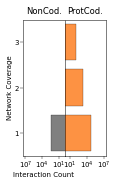

In [55]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(1.5, 2.5), sharey=True, sharex=False, gridspec_kw={'wspace':0})
#sns.barplot(pd.DataFrame({'PC':pc_dict, 'NPC':npc_dict}).NPC, orient='h', color='grey')
sns.barplot(pd.DataFrame({'PC':pc_dict, 'NPC':npc_dict}).PC, orient='h', color='#fd9243', ax=ax[1], edgecolor='black', linewidth=0.25, saturation=1)
ax[1].set_xlabel("Interaction Count")
ax[1].invert_yaxis()
ax[1].set_xscale('log')
sns.barplot(pd.DataFrame({'PC':pc_dict, 'NPC':npc_dict}).NPC, orient='h', color='grey', ax=ax[0], edgecolor='black', linewidth=0.25,  saturation=1)
ax[0].set_xlabel("Interaction Count")
ax[0].set_ylabel("Network Coverage")
ax[0].invert_yaxis()
ax[0].invert_xaxis()
ax[0].set_xscale('log')
ax[0].set_xticks([ 10, 10000, 10000000])
ax[1].set_xticks([ 10, 10000, 10000000])
ax[0].set_xlim( 30000000, 1)
ax[1].set_xlim(1, 30000000)
ax[1].set_xlabel('')
ax[0].set_title('NonCod.')
ax[1].set_title('ProtCod.')
ax[1].tick_params(axis='y', length=0)

#### Interaction features

Citation Count

100%|██████████| 57646/57646 [00:00<00:00, 829852.00it/s]
/tmp/ipykernel_1440029/3964295272.py:9: RuntimeWarning: invalid value encountered in true_divide
  sns.heatmap(bin_counts_uniq/bin_totals, square=True, cmap='gist_heat_r', vmin=0, vmax=0.1, xticklabels=False, yticklabels=False)


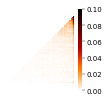

In [56]:
cite_bins, cite_bin_sizes = create_equal_bins(annotation_data, node_list, num_bins=50)
bin_map = map_nodes_to_bins(node_list, annotation_data, cite_bins)
# Observed edges between bins
bin_counts_uniq = get_bin_counts(edge_counts, bin_map, node_mapping, cite_bins)
# Total possible edges between bins
bin_totals = get_bin_totals(cite_bins, cite_bin_sizes)
# Plot results
_ = plt.figure(figsize=(1.5,1.5))
sns.heatmap(bin_counts_uniq/bin_totals, square=True, cmap='gist_heat_r', vmin=0, vmax=0.1, xticklabels=False, yticklabels=False)
plt.gca().invert_yaxis()

mRNA Expression

In [57]:
def get_genes_per_bin(data, bins):
    gene_bins = {}
    for i in range(len(bins)-1):
        genes = data[(data >= bins[i]) & (data < bins[i+1])].index.to_list()
        for gene in genes:
            gene_bins[gene] = bins[i]
    return pd.DataFrame.from_dict({'bin':gene_bins})

In [58]:
rna_bins = np.percentile(gene_mean_rna, q=[i*5 for i in range(21)])
rna_gene_bins = get_genes_per_bin(gene_mean_rna, rna_bins)
rna_gene_bins.index = rna_gene_bins.index.astype(int)

100%|██████████| 57646/57646 [00:00<00:00, 818818.59it/s]
/tmp/ipykernel_1440029/1838630900.py:10: RuntimeWarning: invalid value encountered in true_divide
  sns.heatmap(rna_counts/rna_totals, square=True, cmap='gist_heat_r', vmin=0, vmax=0.1, xticklabels=False, yticklabels=False)


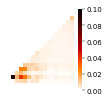

In [59]:
rna_bins = sorted(rna_gene_bins.bin.unique())
rna_bins_dict = {rna_bins[i]:i for i in range(len(rna_bins))}
rna_bin_sizes = rna_gene_bins[rna_gene_bins.index.isin(node_list)].bin.value_counts().sort_index().to_list()
rna_bin_map = rna_gene_bins.loc[:, ('bin')].to_dict()
rna_bin_map = {gene: rna_bins_dict[rna_bin_map[gene]] for gene in rna_bin_map.keys()}
rna_counts = get_bin_counts(edge_counts, rna_bin_map, node_mapping, rna_bins)
rna_totals = get_bin_totals(rna_bins, rna_bin_sizes)

_ = plt.figure(figsize=(1.5, 1.5))
sns.heatmap(rna_counts/rna_totals, square=True, cmap='gist_heat_r', vmin=0, vmax=0.1, xticklabels=False, yticklabels=False)
plt.gca().invert_yaxis()

Protein expression

In [60]:
prot_file = os.path.join(gitdir, 'Data/HPA_normal_tissue_expression.tsv.gz')
prot_data= ExpressionData(prot_file, datatype='protein', min_obs=1000)
gene_mean_prot = prot_data.data.iloc[:, 2:].set_index('Entrez', drop=True).mean(axis=1)

Query batch 0 - 1000
Query batch 1000 - 2000
Query batch 2000 - 3000
Query batch 3000 - 4000
Query batch 4000 - 5000
Query batch 5000 - 6000
Query batch 6000 - 7000
Query batch 7000 - 8000
Query batch 8000 - 9000
Query batch 9000 - 10000
Query batch 10000 - 11000
Query batch 11000 - 11167


In [61]:

bins = np.percentile(gene_mean_prot, q=[i*5 for i in range(21)])
gene_bins = get_genes_per_bin(gene_mean_prot, bins)
gene_bins.index = gene_bins.index.astype(int)

100%|██████████| 57646/57646 [00:00<00:00, 925290.36it/s]
/tmp/ipykernel_1440029/3090196694.py:9: RuntimeWarning: invalid value encountered in true_divide
  sns.heatmap(prot_counts/prot_totals, square=True, cmap='gist_heat_r', vmin=0, vmax=1, xticklabels=False, yticklabels=False)


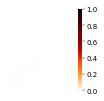

In [62]:
prot_bins = sorted(gene_bins.bin.unique())
prot_bins_dict = {prot_bins[i]:i for i in range(len(prot_bins))}
prot_bin_sizes = gene_bins[gene_bins.index.isin(node_list)].bin.value_counts().sort_index().to_list()
prot_bin_map = gene_bins.loc[:, ('bin')].to_dict()
prot_bin_map = {gene: prot_bins_dict[prot_bin_map[gene]] for gene in prot_bin_map.keys()}
prot_counts = get_bin_counts(edge_counts, prot_bin_map, node_mapping, prot_bins)
prot_totals = get_bin_totals(prot_bins, prot_bin_sizes)
_ = plt.figure(figsize=(1.5, 1.5))
sns.heatmap(prot_counts/prot_totals, square=True, cmap='gist_heat_r', vmin=0, vmax=1, xticklabels=False, yticklabels=False)
plt.gca().invert_yaxis()

Chromosome

In [63]:
chrom_data = annotation_data[(annotation_data.index.isin(node_list)) & (~annotation_data.Chromosome.isin(['other']))].dropna(subset=['Chromosome'])
chrom_bins = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
             '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',
             '21', '22', 'X', 'Y', 'MT']
chrom_bins_dict = {chrom_bins[i]:i for i in range(len(chrom_bins))}
chrom_bin_sizes = [chrom_data.Chromosome.value_counts().loc[c] for c in chrom_bins]
chrom_bin_map = chrom_data.loc[:, ('Chromosome')].to_dict()
chrom_bin_map = {gene: chrom_bins_dict[chrom_bin_map[gene]] for gene in chrom_bin_map.keys() if chrom_bin_map[gene] != 0}

In [64]:
chrom_counts = get_bin_counts(edge_counts, chrom_bin_map, node_mapping, chrom_bins)
chrom_totals = get_bin_totals(chrom_bins, chrom_bin_sizes)

100%|██████████| 57646/57646 [00:00<00:00, 792529.33it/s]


/tmp/ipykernel_1440029/2857901315.py:2: RuntimeWarning: invalid value encountered in true_divide
  sns.heatmap((chrom_counts/chrom_totals), square=True, cmap='gist_heat_r',vmin=0, vmax=0.05, xticklabels=False, yticklabels=False)


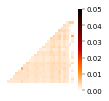

In [65]:
_ = plt.figure(figsize=(1.5, 1.5))
sns.heatmap((chrom_counts/chrom_totals), square=True, cmap='gist_heat_r',vmin=0, vmax=0.05, xticklabels=False, yticklabels=False)
plt.gca().invert_yaxis()

### Fig2E Interaction Network Coverage

In [66]:
interaction_coverage = pd.read_csv(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/Fig2G_interaction_coverage.csv'), index_col=0)

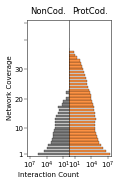

In [67]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(1.5, 2.5), sharey=True, sharex=False, gridspec_kw={'wspace':0})
sns.barplot(interaction_coverage.proteinCoding, orient='h', color='#fd9243', ax=ax[1], edgecolor='black', linewidth=0.25, saturation=1)
ax[1].set_xlabel("Interaction Count")
ax[1].invert_yaxis()
ax[1].set_xscale('log')
sns.barplot(interaction_coverage.nonCoding, orient='h', color='grey', ax=ax[0], edgecolor='black', linewidth=0.25,  saturation=1)

ax[0].set_xlabel("Interaction Count")
ax[0].set_ylabel("Network Coverage")
ax[0].invert_yaxis()
ax[0].invert_xaxis()
ax[0].set_xscale('log')
ax[0].set_xticks([ 10, 10000, 10000000])
ax[1].set_xticks([ 10, 10000, 10000000])
ax[0].set_xlim( 30000000, 1)
ax[1].set_xlim(1, 30000000)
ax[0].set_yticks([0, 9, 19, 29, 39, 45])
ax[1].tick_params(axis='y', length=0)
ax[1].set_xlabel("")
ax[0].set_title('NonCod.')
ax[1].set_title('ProtCod.')
plt.ylim(-0.5, 46)
plt.savefig(figdir+"Fig2F_interaction_coverage.jpg", dpi=400, bbox_inches='tight')

### Fig2F Interaction Feature patterns

In [68]:
citation_bin_data = np.load(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/Fig2H_citation_bin_data.npy'))
mrna_bin_data = np.load(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/Fig2H_mrna_bin_data.npy'))
prot_bin_data = np.load(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/Fig2H_prot_bin_data.npy'))
chrom_bin_data = np.load(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/Fig2H_chrom_bin_data.npy'))


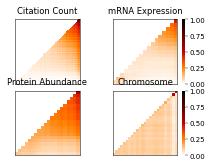

In [69]:
_, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(3.5, 2.5), sharex=False, sharey=False, gridspec_kw={'wspace':0.1, 'hspace':0.1})
sns.heatmap(citation_bin_data, square=True, cmap='gist_heat_r', vmin=0, vmax=1, xticklabels=False, yticklabels=False, ax=ax1, cbar=False)
ax1.invert_yaxis()
ax1.set_title("Citation Count")
sns.heatmap(mrna_bin_data, square=True, cmap='gist_heat_r', vmin=0, vmax=1, xticklabels=False, yticklabels=False, ax=ax2)
ax2.invert_yaxis()
ax2.set_title("mRNA Expression")
sns.heatmap(prot_bin_data, square=True, cmap='gist_heat_r', vmin=0, vmax=1, xticklabels=False, yticklabels=False, ax=ax3, cbar=False)
ax3.invert_yaxis()
ax3.set_title("Protein Abundance")
sns.heatmap(chrom_bin_data, square=True, cmap='gist_heat_r',vmin=0, vmax=1, xticklabels=False, yticklabels=False, ax=ax4)
ax4.invert_yaxis()
ax4.set_title("Chromosome")
for ax in [ax1, ax2, ax3, ax4]:
    ax.spines['right'].set_visible(True)
    ax.spines['top'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
plt.savefig(figdir+"Fig2H_bin_heatmaps.jpg", dpi=400, bbox_inches='tight')

## Supplemental Figures

sizes_over_time - Figure_Stats_Rep.ipynb


### SFig1B - Overall citation/network coverage 

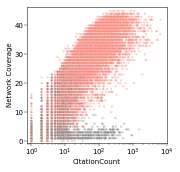

In [70]:
_ = plt.figure(figsize=(2.5,2.5))
sns.scatterplot(data=annotation_data[(annotation_data.PC) | (annotation_data.db_count > 0)], x="CitationCount", y='db_count', size=1, sizes=[5], alpha=0.4, hue='PC', palette=['grey', 'salmon'], legend=False)
plt.xscale("log")
plt.ylabel("Network Coverage")
# add minor ticks
ax = plt.gca()

plt.xlim(0.75, 10000)
plt.ylim(-0.5, 46.5)

plt.savefig(figdir+"Fig2C_citation_scatter.jpg", dpi=800, bbox_inches='tight')

In [71]:
spearmanr(annotation_data[annotation_data.PC].CitationCount, annotation_data[annotation_data.PC].db_count, nan_policy='omit')

SpearmanrResult(correlation=0.8045312878954198, pvalue=0.0)

### SFig1C - Citation vs network coverage for experimental networks

In [72]:
experimental_node_counts = pd.read_csv(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/FigS1c_experimental_node_counts.csv'), index_col=0)

In [73]:
experimental_node_counts = experimental_node_counts.join(annotation_data, how='left')

In [74]:
experimental_node_counts.index = experimental_node_counts.index.astype(int)
# genes with zero citations excluded due to log scale
plot_exp_data = experimental_node_counts[(experimental_node_counts.CitationCount!=0)]
# consider only protein coding genes
plot_exp_data = plot_exp_data[plot_exp_data.PC]

(0.5, 10000)

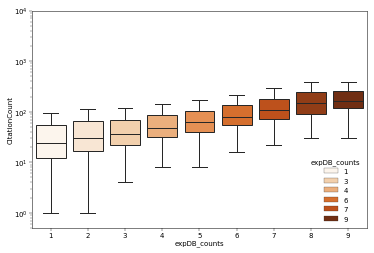

In [75]:
# genes with zero citations excluded due to log scale
sns.boxplot(plot_exp_data, x='expDB_counts', 
            y='CitationCount', hue='expDB_counts', palette='Oranges', fliersize=0, whis=1)
plt.yscale('log')
plt.ylim(0.5, 10000)

In [76]:
spearmanr(plot_exp_data.expDB_counts, plot_exp_data.CitationCount)

SpearmanrResult(correlation=0.48343261104906804, pvalue=0.0)

### SFig1D-E - Overall expression/abundance vs network coverage

#### mRNA Expression

In [77]:
rna_gene_bins = rna_gene_bins.join(annotation_data[annotation_data.PC | annotation_data.db_count > 0])

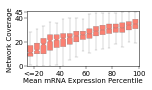

In [78]:
_, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(2, 1))
sns.boxplot(data=rna_gene_bins.loc[rna_gene_bins.PC ==True], x='bin', y='db_count', notch=True, color='salmon', linewidth=0.25, fliersize=0, saturation=1)
ax1 = plt.gca()
_ = ax1.set_xticks([0.5, 4.5,8.5, 12.5, 16.5], labels=["<=20", "40", "60", '80', '100'])
ax1.set_yticks([0, 20, 40, 45])
ax1.set_ylim(0, 45.5)
plt.ylabel("Network Coverage")
plt.xlabel("Mean mRNA Expression Percentile")
plt.savefig(figdir+"Fig2D_mRNA_Expression.jpg", dpi=400, bbox_inches='tight')

In [79]:
spearmanr(rna_gene_bins['bin'], rna_gene_bins['db_count'], nan_policy='omit')

SpearmanrResult(correlation=0.6387133771314468, pvalue=0.0)

#### Protein Abundance

In [80]:
gene_bins = gene_bins.join(annotation_data.loc[annotation_data.PC])

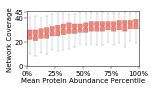

In [81]:
_ = plt.figure(figsize=(2, 1))

sns.boxplot(data=gene_bins, x='bin', y='db_count', notch=True, color='salmon', linewidth=0.25, fliersize=0, saturation=1)

#ax2.set_xlim(0, 2.85)
plt.xlim(-0.5, 19.5)
plt.yticks([0,20, 40, 45])
plt.ylim(0, 45.5)

plt.ylabel("Network Coverage")

plt.xlabel("Mean Protein Abundance Percentile")
_  = plt.xticks([-0.5, 4.5, 9.5, 14.5, 19.5], labels=["0%", "25%", '50%', '75%', '100%'])
plt.savefig(figdir+"Fig2E_protein_expression.jpg", dpi=400, bbox_inches='tight')

In [82]:
spearmanr(gene_bins['bin'], gene_bins['db_count'],  nan_policy='omit')

SpearmanrResult(correlation=0.39817371199610746, pvalue=0.0)

### SFig1F - Gene conservation bias

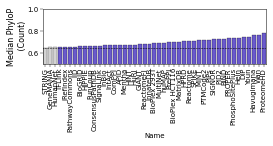

In [83]:
_ = plt.figure(figsize=(4,1))

plot_bar_v(bias_data[bias_data.Annotation=='Conservation'], 'PhyloP\n', 'Count', 'Median', ax=plt.gca(),
           color='slateblue', ylim=(0.5, 1),edgecolor='black', linewidth=0.25)


### SFig2 - Tissue-enhanced mRNA

#### Example analysis

In [84]:
gene_class, tiss_genes = classify_genes(rna_data.data, min_exp=1, ratio=5, n_group=7, exclude_cols=2)

34812it [05:32, 104.70it/s]


In [85]:
classifications = defaultdict(int)
for k in tqdm(gene_class):
    classifications[list(gene_class[k].keys())[0]] += 1
print(classifications)

100%|██████████| 34812/34812 [00:00<00:00, 1240418.23it/s]

defaultdict(<class 'int'>, {'Low Expression': 11810, 'Not Classified': 10271, 'Tissue Enhanced': 8467, 'Group Enriched': 739, 'Tissue Enriched': 3525})


In [87]:
mrna_enhance = []
tiss_data = rna_data.data.loc[rna_data.data.index.isin(gene_mean_rna.index.tolist())]
for net in tqdm([x for x in stats.network_names]):
    nodes = load_nodes(stats.node_files[net]).Node.values
    res = get_stats_tissue_enriched(tiss_data, nodes, tiss_genes,  use_classes = ['Tissue Enriched', 'Group Enriched', 'Tissue Enhanced'], min_tiss_genes=10)
    res['Network'] = net
    mrna_enhance.append(res)
pd.concat(mrna_enhance).to_csv(os.path.join(gitdir, 'Data/example_outputs/mRNA_tissue_enrichment.tsv'), sep='\t')

100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


#### Full plot

In [88]:
from statsmodels.stats.multitest import fdrcorrection
from matplotlib.cm import ScalarMappable

def plot_bubble( data,net_names, x_order=None, y_order=None,  ax=None,
                size_range=(5, 100), size_norm=(1, 5), marker='o', limit=10):
    data_df = data.copy()
    data_df['direction'] = data_df['stat'].apply(lambda x: 1 if x >= 1 else -1)
    data_df['Name'] = data_df.index

    data_df['plot_p'] = -np.log10(fdrcorrection(data_df['P-value'])[1]) * data_df['direction']
    data_df['plot_stat'] = data_df.stat.apply(lambda x: x if x>1 else 1/(x+0.00001))
    value_mat = data_df.pivot_table(index='Network', columns='Name', values='plot_p')
    cg = sns.clustermap(value_mat)
    if x_order is None:
        x_order = {value_mat.columns.values[idx]:i for i, idx in enumerate(cg.dendrogram_col.reordered_ind)}
    if y_order is None:
        cg = sns.clustermap(value_mat, col_cluster=False)
        y_order = {value_mat.index.values[idx]:i for i, idx in enumerate(cg.dendrogram_row.reordered_ind)}
        plt.close()

    data_df["x"] = data_df["Name"].apply(lambda x: x_order[x])
    data_df["y"] = data_df["Network"].apply(lambda y: y_order[y])
    plt.close()
    
    scales = np.linspace(-1 * limit, limit, 100)
    cmap= plt.get_cmap('RdBu_r')
    norm = plt.Normalize(vmin=-1 * limit, vmax=limit)
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(0.16 * len(x_order),0.12 * len(y_order)), linewidth=0.5)
    plt.sca(ax)
    data_df['marker']= 'test'
    res = sns.scatterplot(data=data_df,x='x', y='y', hue='plot_p', size='plot_stat', palette='RdBu_r', hue_norm=(-10, 10),
                    sizes=size_range, ax=ax, legend=False, size_norm=size_norm, style='marker', markers=[marker], edgecolor='black', linewidth=0.1)
    #res = sns.relplot(data=data_df,x='x', y='y', hue='plot_p', size='plot_oe', palette='RdBu', hue_norm=(-10, 10), 
    #                sizes=(5,100), height = 0.2 * len(y_order), aspect = 0.8, legend='brief')
    plt.xticks(list(x_order.values()), list(x_order.keys()), rotation=90, fontsize=7)

    plt.yticks(list(y_order.values()), [net_names[y] for y in y_order.keys()], fontsize=7)
    plt.xlim(-0.5, len(x_order)-0.5)
    plt.ylim(-0.5, len(y_order)-0.5)
    #sns.move_legend(res, (1.05,0))
    for y in range(len(y_order)-1):
        plt.hlines(y+0.5, -1, len(x_order), color='grey', linewidth=0.25)
    for x in range(len(x_order)-1):
        plt.vlines(x+0.5, -1, len(y_order), color='grey', linewidth=0.25)
    cbar = fig.colorbar(sm, ax= ax, label="-log10(q)")
    #cbar.ax.set_label("-log10(q)", fontsize=7)
    cbar.ax.tick_params(labelsize=7, length=2, pad=1)
    h, l = create_size_legend(size_range, size_norm, [i for i in range(size_norm[0], size_norm[1]+1)], marker=marker)
    _ = plt.legend(handles=h, labels=l, loc=(2,0.5), title='Effect Size', fontsize=7)
    return x_order, y_order

def create_size_legend(size_range, size_norm, points_to_plot, marker='o'):
    handles = []
    labels = [str(x)+'x' for x in points_to_plot]
    for point in points_to_plot:
        multiplier = (point-size_norm[0])/(size_norm[1] - size_norm[0])
        val = size_range[0] + (size_range[1] - size_range[0])* multiplier
        handles.append(plt.scatter([], [], s=val, color='black', label=str(point), marker=marker, linewidth=0))
    labels[-1] = '>'+labels[-1]
    return handles, labels

In [89]:
## Load the full data
tissue_exp_enhance = pd.read_csv(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/FigS2_tissue_mrna_data.tsv'), sep='\t', index_col=0)
tissue_exp_enhance['direction'] = tissue_exp_enhance['stat'].apply(lambda x: 1 if x >= 1 else -1)
tissue_exp_enhance['Name'] = tissue_exp_enhance.index

/cellar/users/snwright/anaconda3/envs/pcnet_py3/lib/python3.10/site-packages/matplotlib/colors.py:1254: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)


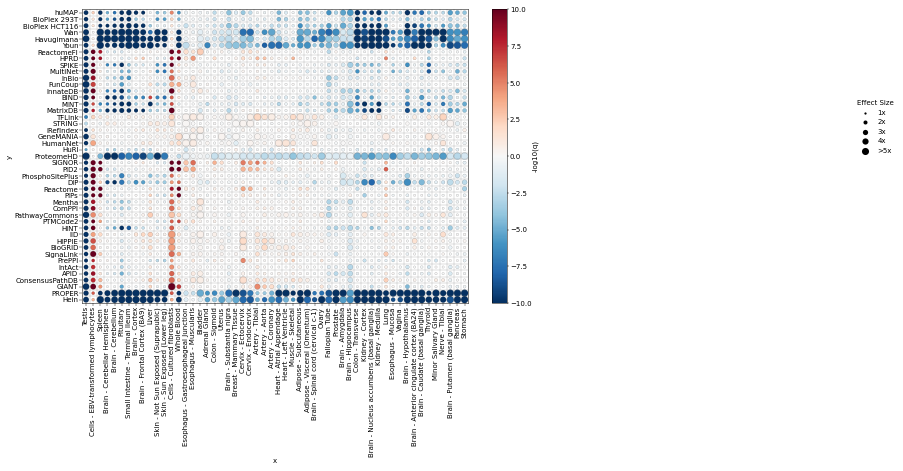

In [90]:
_, _ = plot_bubble(tissue_exp_enhance, size_norm=(1,5),size_range=(5, 50), 
                net_names={net:network_names[net] for net in tissue_exp_enhance.Network.unique()}, marker='o', limit=10)
plt.savefig(os.path.join(figdir, 'FigS2_tissue_mRNA.jpg'), dpi=400, bbox_inches='tight')

### SFig3 - Tissue-enhanced Protein
#### Example analysis

In [91]:
all_prot_data = prot_data.data.set_index('Entrez')
prot_class, tiss_genes_prot = classify_genes(all_prot_data,  min_exp=0.5, ratio=3, n_group=7, exclude_cols=3)

11131it [02:27, 75.26it/s]


In [92]:
prot_classifications = defaultdict(int)
for k in tqdm(prot_class):
    prot_classifications[list(prot_class[k].keys())[0]] += 1
print(prot_classifications)

100%|██████████| 11131/11131 [00:00<00:00, 1217387.17it/s]

defaultdict(<class 'int'>, {'Low Expression': 520, 'Tissue Enhanced': 2716, 'Group Enriched': 883, 'Not Classified': 6474, 'Tissue Enriched': 538})


In [93]:
prot_enhance = []
data_prot = all_prot_data.loc[all_prot_data.index.isin(gene_mean_prot.index.tolist())]
for net in tqdm([x for x in stats.network_names]):
    nodes = load_nodes(stats.node_files[net]).Node.values
    res = get_stats_tissue_enriched(data_prot, nodes, tiss_genes_prot,  use_classes = ['Tissue Enriched', 'Group Enriched'], min_tiss_genes=10)
    res['Network'] = net
    prot_enhance.append(res)
pd.concat(prot_enhance).to_csv(os.path.join(gitdir, 'Data/example_outputs/prot_tissue_enrichment.tsv'), sep='\t')

100%|██████████| 3/3 [00:03<00:00,  1.26s/it]


#### Full plot


In [94]:
tissue_prot_enhance = pd.read_csv(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/FigS3_tissue_prot_data.tsv'), sep='\t', index_col=0)
tissue_prot_enhance['direction'] = tissue_prot_enhance['stat'].apply(lambda x: 1 if x >= 1 else -1)
tissue_prot_enhance['Name'] = tissue_prot_enhance.index

/cellar/users/snwright/anaconda3/envs/pcnet_py3/lib/python3.10/site-packages/matplotlib/colors.py:1254: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)


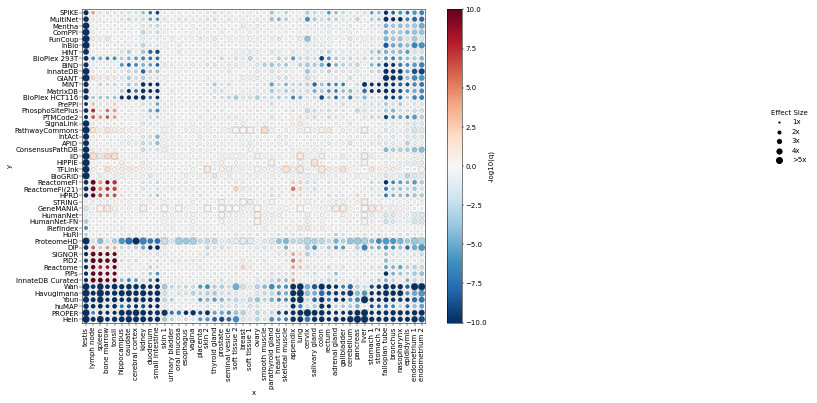

In [95]:
_, _ = plot_bubble(tissue_prot_enhance, size_norm=(1,5),size_range=(5, 50), 
                net_names={net:network_names[net] for net in tissue_prot_enhance.Network.unique()}, marker='o', limit=10)
plt.savefig(os.path.join(figdir, 'FigS3_tissue_protein.jpg'), dpi=400, bbox_inches='tight')

### SFig4A Regression of expression and citation count

In [96]:
gene_mean_prot.index.name=None
gene_mean_prot.index = gene_mean_prot.index.astype(int)
cite_exp = annotation_data[annotation_data.PC | annotation_data.db_count > 0].join(pd.DataFrame({'rna':gene_mean_rna})).join(pd.DataFrame({'prot':gene_mean_prot}))

In [97]:
regress_data = cite_exp[cite_exp.PC].dropna(subset=['rna', 'CitationCount'])
regress_data = regress_data[regress_data['CitationCount'] > 0]
regress_data['logrna'] = np.log10(regress_data['rna']+1e-3)
regress_data['logCitationCount'] = np.log10(regress_data['CitationCount'])

intercept    1.450001
logrna       0.254494
dtype: float64


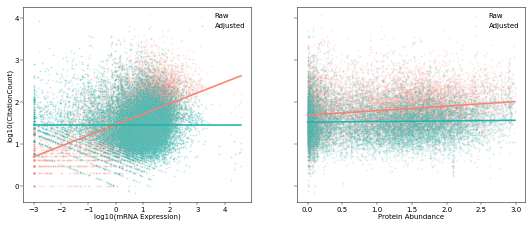

In [98]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Add constant column for intercept
regress_data['intercept'] = 1
df = regress_data[regress_data.PC].dropna(subset=['logCitationCount', 'logrna'])
df.sort_values(by='logCitationCount', inplace=True, ascending=True)
# Fit the regression model
model = sm.OLS(df['logCitationCount'], df[['intercept', 'logrna']])
results = model.fit()
print(results.params)

# Step 2: Generate adjusted citation counts
df['adjCitationCount'] = df['logCitationCount'] - results.predict(df[['intercept', 'logrna']]) + results.params['intercept']

_, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(9, 1.2*3), sharey=True)

# Step 3: Plot the original relationship of CitationCount to db_count with fit line
sns.scatterplot(df, y='logCitationCount', x = 'logrna', label='Raw', alpha=0.2, s=3, ax=ax1, color='salmon')
# add linear fit line
sns.regplot(data=df, y='logCitationCount', x = 'logrna', scatter=False, ax=ax1, color='salmon',line_kws={'linewidth':1.5})
# Step 4: Plot the adjusted relationship of CitationCount to db_count
sns.scatterplot(df, y='adjCitationCount', x = 'logrna', label='Adjusted', alpha=0.3, s=3, ax=ax1, color='lightseagreen') #ax=ax)
sns.regplot(data=df, y='adjCitationCount', x = 'logrna', scatter=False, ax=ax1, color='lightseagreen',line_kws={'linewidth':1.5})

sns.scatterplot(df, y='logCitationCount', x = 'prot', label='Raw', alpha=0.2, s=3, ax=ax2, color='salmon')
sns.regplot(data=df, y='logCitationCount', x = 'prot', scatter=False, ax=ax2, color='salmon',line_kws={'linewidth':1.5})
# Step 4: Plot the adjusted relationship of CitationCount to db_count
sns.scatterplot(df, y='adjCitationCount', x = 'prot', label='Adjusted', alpha=0.2, s=3, ax=ax2, color='lightseagreen') #ax=ax)
sns.regplot(data=df, y='adjCitationCount', x = 'prot', scatter=False, ax=ax2, color='lightseagreen',line_kws={'linewidth':1.5})
# remove legend
#ax1.get_legend().remove()
#ax2.get_legend().remove()

for i, ax in enumerate([ax1, ax2]):
    ax.set_xlabel(['log10(mRNA Expression)', 'Protein Abundance', ['log10(Citation Count)']][i])
    ax.set_ylabel(['log10(CitationCount)', 'log10(CitationCount)', 'Network Coverage'][i])
    
plt.savefig(figdir+"SFig2B_expression_regression_1.png", dpi=500, bbox_inches='tight')



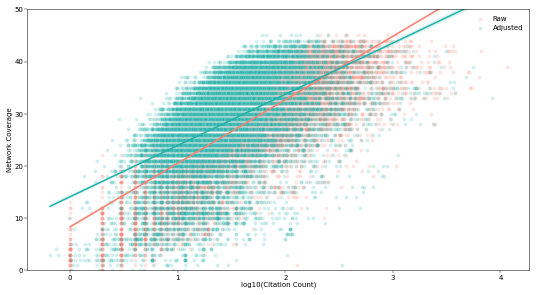

In [99]:
_, ax3 = plt.subplots(nrows=1, ncols=1, figsize=(9, 1.6*3))
sns.scatterplot(df, x='logCitationCount', y = 'db_count', label='Raw', alpha=0.2, s=15, ax=ax3, color='salmon')
sns.regplot(data=df, x='logCitationCount', y = 'db_count', scatter=False, ax=ax3, color='salmon',line_kws={'linewidth':1.5})
# Step 4: Plot the adjusted relationship of CitationCount to db_count
sns.scatterplot(df, x='adjCitationCount', y = 'db_count', label='Adjusted', alpha=0.2, s=15, ax=ax3, color='lightseagreen') #ax=ax)
sns.regplot(data=df, x='adjCitationCount', y = 'db_count', scatter=False, ax=ax3, color='lightseagreen',line_kws={'linewidth':1.5})
ax3.set_ylim(0,50)
ax3.set_ylabel('Network Coverage')
ax3.set_xlabel('log10(Citation Count)')
plt.savefig(figdir+"SFig2B_expression_regression_2.png", dpi=500, bbox_inches='tight')

### SFig4B - Tissue-specific interaction density

#### Example analysis

In [100]:
node_list = annotation_data[annotation_data.db_count > 0].index.values
node_list = [x for x in node_list if x in pc_genes]

In [101]:
rna_bins = sorted(rna_gene_bins.bin.unique())
rna_bins_dict = {rna_bins[i]:i for i in range(len(rna_bins))}
rna_bin_sizes = rna_gene_bins[rna_gene_bins.index.isin(node_list)].bin.value_counts().sort_index().to_list()
rna_bin_map = rna_gene_bins.loc[:, ('bin')].to_dict()
rna_bin_map = {gene: rna_bins_dict[rna_bin_map[gene]] for gene in rna_bin_map.keys()}

In [102]:
# identify the low expression genes with elevated interaction density
rev_rna_bin_map = defaultdict(list)
for k, v in rna_bin_map.items():
    rev_rna_bin_map[v].append(k)
all_bin1_genes = rev_rna_bin_map[1]
print(len(all_bin1_genes))

1740


In [103]:
gene_non_zero_mrna = rna_data.data.loc[:, rna_data.data.columns[2:-1]].apply(lambda x: sum(x >0), axis=1)
gene_non_zero_mrna.index.name=None

In [104]:
# From these, select the gene that appear to be tissue specific
bin1_genes = [gene for gene in all_bin1_genes if gene_non_zero_mrna[gene] <= 2]
print(len(bin1_genes))

1400


In [105]:
bin1_mrna = rna_data.data.loc[bin1_genes]

In [106]:
# from these genes, create tissue specific gene bins
tissue_bins = defaultdict(list)
for tissue in bin1_mrna.columns[2:]:
    tissue_bins[tissue] = bin1_mrna[bin1_mrna[tissue] > 0].index.to_list()
    
tissue_bins = {k: v for k, v in tissue_bins.items() if len(v) > 1}
tiss_bins = list(tissue_bins.keys())
tiss_bins_dict = {tiss_bins[i]:i for i in range(len(tiss_bins))}
tiss_bin_sizes = [len(tissue_bins[x]) for x in tiss_bins_dict]
tiss_bin_map = {gene: tiss_bins_dict[tissue] for tissue in tissue_bins for gene in tissue_bins[tissue]}

In [107]:
# Load the edge_counts
with open(os.path.join(gitdir, "Data/example_outputs/edge_counts.pkl"), "rb") as f:
    edge_counts = pickle.load(f)
# Load the node_mapping
with open(os.path.join(gitdir, "Data/example_outputs/node_mapping.pkl"), "rb") as f:
    node_mapping = pickle.load(f)

In [108]:
tiss_counts = get_bin_counts(edge_counts, tiss_bin_map, node_mapping, tiss_bins)

100%|██████████| 57646/57646 [00:00<00:00, 1801245.97it/s]


In [109]:
tiss_totals = get_bin_totals(tiss_bins, tiss_bin_sizes)

In [110]:
cluster_data = ((tiss_counts + np.transpose(tiss_counts) - np.diag(np.diag(tiss_counts)))/(tiss_totals+ np.transpose(tiss_totals) - np.diag(np.diag(tiss_totals))))
# drop rows or columns with sum of zero
drop_rows= cluster_data.sum(axis=1) == 0
# drop rows and columns from array
cluster_data = cluster_data[~drop_rows]
cluster_data = cluster_data[:, ~drop_rows]

In this reduced analysis, we compare the number of interactions among tissue-specific genes for the three example networks to the total for all genes giving a small number of tissues and low interaction densities

<Figure size 360x360 with 0 Axes>

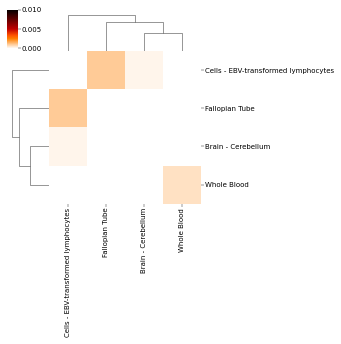

In [111]:
_ = plt.figure(figsize=(5, 5))
#sns.heatmap((tiss_counts/tiss_totals), square=True, cmap='gist_heat_r',vmin=0, xticklabels=False, yticklabels=False)

cg = sns.clustermap(cluster_data, cmap='gist_heat_r',vmin=0,vmax=0.01, xticklabels=True, yticklabels=True, figsize=(3,3))
# add reordered tick labels
tissue_labels=[t for i, t in enumerate(tiss_bins) if not drop_rows[i]]
new_order = [tissue_labels[i] for i in cg.dendrogram_row.reordered_ind]
_ = cg.ax_heatmap.set_yticklabels(new_order, rotation=0)
_ = cg.ax_heatmap.set_xticklabels(new_order, rotation=90)


#### Full plot

In [112]:
cluster_data = pd.read_csv(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/FigS4B_interaction_density_tissue.tsv'), sep='\t', index_col=0)
tissue_labels = cluster_data.columns

<Figure size 360x360 with 0 Axes>

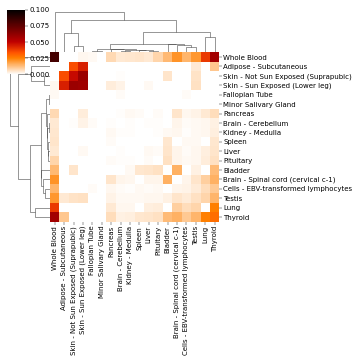

In [113]:
_ = plt.figure(figsize=(5, 5))
#sns.heatmap((tiss_counts/tiss_totals), square=True, cmap='gist_heat_r',vmin=0, xticklabels=False, yticklabels=False)

cg = sns.clustermap(cluster_data, cmap='gist_heat_r',vmin=0,vmax=0.10, xticklabels=True, yticklabels=True, figsize=(5,5))
# add reordered tick labels

new_order = [tissue_labels[i] for i in cg.dendrogram_row.reordered_ind]
_ = cg.ax_heatmap.set_yticklabels(new_order, rotation=0)
_ = cg.ax_heatmap.set_xticklabels(new_order, rotation=90)